# **실습 3-1 : RNN Basic**


## **Import Module**

In [0]:
%tensorflow_version 2.x

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


tf.__version__

TensorFlow 2.x selected.


'2.0.0'

## **DataSet**

### Mount

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load

In [0]:
import pandas as pd
# data file path declare
stock_file = '/content/drive/Shared drives/scsa_2019_e/z_data/data-02-stock_daily.csv'
# read the data file
pd_data = pd.read_csv(stock_file)
# 처음 몇개 자료 확인
pd_data.head()

,,,,# http://finance.yahoo.com/quote/GOOG/history?ltr=1
# Open,High,Low,Volume,Close
828.659973,833.450012,828.349976,1247700,831.659973
823.02002,828.070007,821.655029,1597800,828.070007
819.929993,824.400024,818.97998,1281700,824.159973
819.359985,823,818.469971,1304000,818.97998


### Check dataset

### Preprocessing

In [0]:
# 최대,최소값으로 정규화 하기
def MinMaxScaler(data):
  numerator = data - np.min(data, 0)
  denominator = (np.max(data, 0) - np.min(data, 0)) + 1e-7
  return numerator/denominator

In [0]:
# data loading: csv file에서 숫자 데이터를 ndarray로 load
xy = np.loadtxt(stock_file, delimiter=',')

xy = xy[::-1]           # 과거부터로 정렬 (chronically ordered)
xy = MinMaxScaler(xy)   # minmax 정규화
x = xy                  # input data(Open,High,Low,Volume)

y = xy[:, [-1]]         # 종가만 slicing -> target data

# data type 확인
print ("SHAPE OF X IS %s" % (x.shape,))
print ("SHAPE OF Y IS %s" % (y.shape,))

SHAPE OF X IS (732, 5)
SHAPE OF Y IS (732, 1)


In [0]:
# sequence generator
## x:7일치 데이터, y:8일차 종가
timesteps = seq_length = 7
data_dim  = 5
dataX = []
dataY = []
print(len(y))
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length] # 7일치 데이터
    _y = y[i + seq_length]   # 다음날 종가
    dataX.append(_x)
    dataY.append(_y)

# train data : test data = 7 : 3
train_size = int(len(dataY) * 0.7)
test_size  = len(dataY) - train_size
x_train = np.array(dataX[0:train_size])
y_train = np.array(dataY[0:train_size])
x_test  = np.array(dataX[train_size:len(dataX)])
y_test  = np.array(dataY[train_size:len(dataY)])

732


In [0]:
def print_np(_name, _x):
    print("TYPE  OF [%s] is [%s]" % (_name, type(_x)))
    print("SHAPE OF [%s] is %s" % (_name, _x.shape))

In [0]:
print_np('x_train', x_train)
print_np('y_train', y_train)
print_np('x_test', x_test)
print_np('y_test', y_test)

TYPE  OF [x_train] is [<class 'numpy.ndarray'>]
SHAPE OF [x_train] is (507, 7, 5)
TYPE  OF [y_train] is [<class 'numpy.ndarray'>]
SHAPE OF [y_train] is (507, 1)
TYPE  OF [x_test] is [<class 'numpy.ndarray'>]
SHAPE OF [x_test] is (218, 7, 5)
TYPE  OF [y_test] is [<class 'numpy.ndarray'>]
SHAPE OF [y_test] is (218, 1)


## **Model**

### Define

In [0]:
hidden_dim = 6

#### Basic LSTM model 
#basic model = LSTM + dense
model_B = tf.keras.models.Sequential(name='model_basic')  
model_B.add(tf.keras.layers.LSTM(units = hidden_dim, 
              input_shape = (x_train.shape[1], x_train.shape[2])))
model_B.add(tf.keras.layers.Dense(units = 1))

#### Advanced model: stacked LSTM
#Advance mode = (LSTM) * 3 + dense
# layer 1
model_A = tf.keras.models.Sequential(name='model_advanced') 
model_A.add(tf.keras.layers.LSTM(units = hidden_dim, # 10개. 
              return_sequences = True, 
              input_shape = (x_train.shape[1], x_train.shape[2])))
# layer 2
model_A.add(tf.keras.layers.LSTM(units = hidden_dim,return_sequences = True)) # return sequence를 true로 해주면 쌓는 것이 가능. Stacked를 만들거라면 쌓아주면 된다.
# layer 3
model_A.add(tf.keras.layers.LSTM(units = hidden_dim))
# dense
model_A.add(tf.keras.layers.Dense(units = 1))

# model summary
model_B.summary()   # basic model
model_A.summary()   # advanced model



Model: "model_basic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 288       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 295
Trainable params: 295
Non-trainable params: 0
_________________________________________________________________
Model: "model_advanced"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 6)              288       
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 6)              312       
_________________________________________________________________
lstm_3 (LSTM)                (None, 6)                 312       
_________________________________

### Compile and Fit

Epoch 100/100
507/507 [==============================] - 0s 220us/sample - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0019
CPU times: user 17.2 s, sys: 910 ms, total: 18.1 s

Wall time: 14.4 s (@Notebook Setting/GPU)

In [0]:
%%time
# model compile
model_B.compile(optimizer = 'adam', loss = 'mse', metrics=['mse'])

history_B = model_B.fit(x_train, y_train, 
                      validation_data=(x_test, y_test),
                      epochs = 100, batch_size = 32)

Train on 507 samples, validate on 218 samples
Epoch 1/100
507/507 [==============================] - 5s 10ms/sample - loss: 0.0949 - mse: 0.0949 - val_loss: 0.1333 - val_mse: 0.1333
Epoch 2/100
507/507 [==============================] - 0s 169us/sample - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 3/100
507/507 [==============================] - 0s 174us/sample - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 4/100
507/507 [==============================] - 0s 170us/sample - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 5/100
507/507 [==============================] - 0s 201us/sample - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/100
507/507 [==============================] - 0s 190us/sample - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/100
507/507 [==============================] - 0s 172us/sample - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0033 - val_mse: 0.0

Epoch 100/100
507/507 [==============================] - 0s 563us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0090 - val_mse: 0.0090
CPU times: user 50.9 s, sys: 2.65 s, total: 53.6 s

Wall time: 36.8 s

In [0]:
%%time
# model compile
model_A.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

history_A = model_A.fit(x_train, y_train, 
                      validation_data=(x_test, y_test),
                      epochs = 100, batch_size = 32)


Train on 507 samples, validate on 218 samples
Epoch 1/100
507/507 [==============================] - 4s 9ms/sample - loss: 0.0917 - mse: 0.0917 - val_loss: 0.3114 - val_mse: 0.3114
Epoch 2/100
507/507 [==============================] - 0s 316us/sample - loss: 0.0373 - mse: 0.0373 - val_loss: 0.1192 - val_mse: 0.1192
Epoch 3/100
507/507 [==============================] - 0s 283us/sample - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0716 - val_mse: 0.0716
Epoch 4/100
507/507 [==============================] - 0s 306us/sample - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0613 - val_mse: 0.0613
Epoch 5/100
507/507 [==============================] - 0s 313us/sample - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 6/100
507/507 [==============================] - 0s 273us/sample - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 7/100
507/507 [==============================] - 0s 272us/sample - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0046 - val_mse: 0.00

## **Analysis**

### Plot

In [0]:
print(history_B.history.keys())   # check generated metrics

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


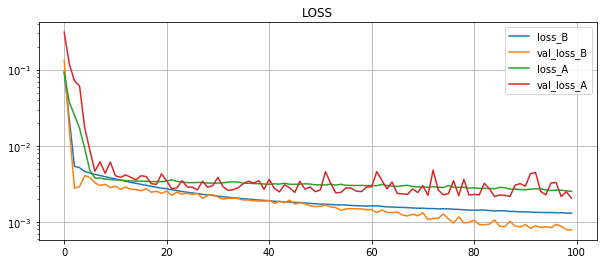

In [0]:
losses_B = history_B.history['loss']
val_loss_B = history_B.history['val_loss']
losses_A = history_A.history['loss']
val_loss_A = history_A.history['val_loss']
plt.figure(figsize=(10, 4))
plt.semilogy(losses_B, label='loss_B')
plt.semilogy(val_loss_B, label='val_loss_B')
plt.semilogy(losses_A, label='loss_A')
plt.semilogy(val_loss_A, label='val_loss_A')
plt.grid(True)
plt.legend(loc='best')
plt.title("LOSS")
plt.show()  

### Predict the stock price

In [0]:
predicted_stock_price_B = model_B.predict(x_test)
predicted_stock_price_A = model_A.predict(x_test)

### Plot the result

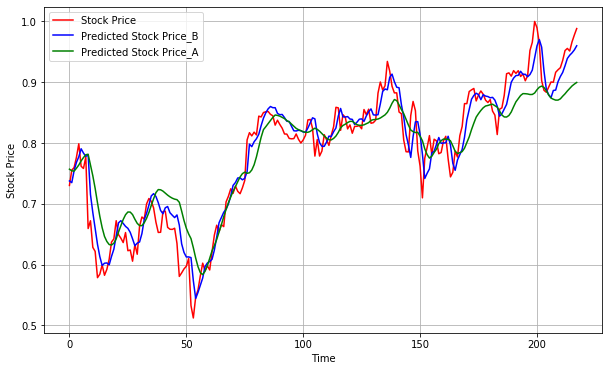

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, color = 'red', label = 'Stock Price')
plt.plot(predicted_stock_price_B, color = 'blue', label = 'Predicted Stock Price_B')
plt.plot(predicted_stock_price_A, color = 'green', label = 'Predicted Stock Price_A')
#plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## **실습 과제**

### 과제 1. `timesteps = seq_length = 7`를 줄여보자 
#### -- model_B에서 5,3,1로 줄이고 결과를 비교하자:

5일때의 결과값 : loss: 0.0011 - mse: 0.0011 - val_loss: 7.7446e-04

3일때의 결과값 : loss: 0.0018 - mse: 0.0018 - val_loss: 0.0022 - val_mse: 0.0022

1일때의 결과값 : loss: 0.0010 - mse: 0.0010 - val_loss: 0.0023 - val_mse: 0.0023

시퀀스의 길이가 짧다고 항상 좋은 결과가 잘 나오는 것은 아니다. 특히나 시퀀스가 1인 경우는 사실상 한 단어씩 보는 것이나 마찬가지기 때문에 RNN을 하는 의미가 없다.

In [0]:
#과제 1 5로 줄이기
# sequence generator
timesteps = seq_length = 1 # 시퀀스 데이터를 넣어주는 것이 더 중요하다/
data_dim  = 5
dataX = []
dataY = []
print(len(y))
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length] # 7일치 데이터
    _y = y[i + seq_length]   # 다음날 종가
    dataX.append(_x)
    dataY.append(_y)
print(dataX)
# train data : test data = 7 : 3
train_size = int(len(dataY) * 0.7)
test_size  = len(dataY) - train_size
x_train = np.array(dataX[0:train_size])
y_train = np.array(dataY[0:train_size])
x_test  = np.array(dataX[train_size:len(dataX)])
y_test  = np.array(dataY[train_size:len(dataY)])

732
[array([[0.21375105, 0.20817981, 0.19179183, 0.00046608, 0.1920924 ]]), array([[0.19393503, 0.20364193, 0.20866457, 0.00298467, 0.19655155]]), array([[0.21051645, 0.20528941, 0.20355875, 0.00025993, 0.18774973]]), array([[0.18667876, 0.20948057, 0.20878184, 0.        , 0.21744815]]), array([[0.30697388, 0.31463414, 0.21899367, 0.01247647, 0.21698189]]), array([[0.21914211, 0.26390721, 0.2246864 , 0.45632338, 0.22496747]]), array([[0.23312993, 0.23641916, 0.16268272, 0.57017119, 0.14744274]]), array([[0.13431201, 0.15175877, 0.11617252, 0.39380658, 0.13289962]]), array([[0.13973232, 0.17060429, 0.15860382, 0.28173344, 0.18171679]]), array([[0.18933069, 0.20057799, 0.19187983, 0.29783096, 0.2086465 ]]), array([[0.20500875, 0.19950862, 0.153586  , 0.36110962, 0.14106001]]), array([[0.11044525, 0.12724798, 0.11435324, 0.35107108, 0.11089532]]), array([[0.12705592, 0.1390988 , 0.12324434, 0.23008873, 0.11649107]]), array([[0.12288872, 0.12276776, 0.09067269, 0.34481491, 0.12791587]]), a

In [0]:
hidden_dim = 10

#### Basic LSTM model 
#basic model = LSTM + dense
model_B = tf.keras.models.Sequential(name='model_basic')  
model_B.add(tf.keras.layers.LSTM(units = hidden_dim, 
              input_shape = (x_train.shape[1], x_train.shape[2])))
model_B.add(tf.keras.layers.Dense(units = 1))

#### Advanced model: stacked LSTM
#Advance mode = (LSTM) * 3 + dense
# layer 1
model_A = tf.keras.models.Sequential(name='model_advanced') 
model_A.add(tf.keras.layers.LSTM(units = hidden_dim, # 10개. 
              return_sequences = True, 
              input_shape = (x_train.shape[1], x_train.shape[2])))
# layer 2
model_A.add(tf.keras.layers.LSTM(units = hidden_dim,return_sequences = True)) # return sequence를 true로 해주면 쌓는 것이 가능. Stacked를 만들거라면 쌓아주면 된다.
# layer 3
model_A.add(tf.keras.layers.LSTM(units = hidden_dim))
# dense
model_A.add(tf.keras.layers.Dense(units = 1))

# model summary
model_B.summary()   # basic model
model_A.summary()   # advanced model



Model: "model_basic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 651
Trainable params: 651
Non-trainable params: 0
_________________________________________________________________
Model: "model_advanced"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 10)             640       
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                840       
_________________________________

In [0]:
%%time
# model compile
model_B.compile(optimizer = 'adam', loss = 'mse', metrics=['mse'])

history_B = model_B.fit(x_train, y_train, 
                      validation_data=(x_test, y_test),
                      epochs = 100, batch_size = 32)

Train on 511 samples, validate on 220 samples
Epoch 1/100
511/511 [==============================] - 2s 4ms/sample - loss: 0.0685 - mse: 0.0685 - val_loss: 0.2497 - val_mse: 0.2497
Epoch 2/100
511/511 [==============================] - 0s 168us/sample - loss: 0.0424 - mse: 0.0424 - val_loss: 0.1617 - val_mse: 0.1617
Epoch 3/100
511/511 [==============================] - 0s 181us/sample - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0945 - val_mse: 0.0945
Epoch 4/100
511/511 [==============================] - 0s 164us/sample - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 5/100
511/511 [==============================] - 0s 163us/sample - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0279 - val_mse: 0.0279
Epoch 6/100
511/511 [==============================] - 0s 178us/sample - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 7/100
511/511 [==============================] - 0s 175us/sample - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0123 - val_mse: 0.01

In [0]:
%%time
# model compile
model_A.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

history_A = model_A.fit(x_train, y_train, 
                      validation_data=(x_test, y_test),
                      epochs = 100, batch_size = 32)


Train on 511 samples, validate on 220 samples
Epoch 1/100
511/511 [==============================] - 5s 9ms/sample - loss: 0.1385 - mse: 0.1385 - val_loss: 0.5668 - val_mse: 0.5668
Epoch 2/100
511/511 [==============================] - 0s 264us/sample - loss: 0.1185 - mse: 0.1185 - val_loss: 0.5044 - val_mse: 0.5044
Epoch 3/100
511/511 [==============================] - 0s 259us/sample - loss: 0.0970 - mse: 0.0970 - val_loss: 0.4288 - val_mse: 0.4288
Epoch 4/100
511/511 [==============================] - 0s 277us/sample - loss: 0.0737 - mse: 0.0737 - val_loss: 0.3329 - val_mse: 0.3329
Epoch 5/100
511/511 [==============================] - 0s 265us/sample - loss: 0.0507 - mse: 0.0507 - val_loss: 0.2149 - val_mse: 0.2149
Epoch 6/100
511/511 [==============================] - 0s 252us/sample - loss: 0.0327 - mse: 0.0327 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 7/100
511/511 [==============================] - 0s 260us/sample - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0599 - val_mse: 0.05

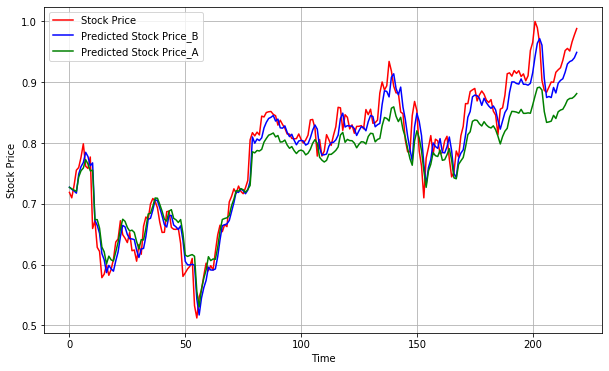

In [0]:
predicted_stock_price_B = model_B.predict(x_test)
predicted_stock_price_A = model_A.predict(x_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test, color = 'red', label = 'Stock Price')
plt.plot(predicted_stock_price_B, color = 'blue', label = 'Predicted Stock Price_B')
plt.plot(predicted_stock_price_A, color = 'green', label = 'Predicted Stock Price_A')
#plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

### 과제 2. model_A를 교재와 같이 확장시켜 model_A2를 만들어 보자
#### -- dropout layer를 추가하고, 
#### -- LSTM layer도 추가하자
#### -- 결과를 model_B,A,A2에 대해 비교하자:






In [0]:
model_A2 = tf.keras.models.Sequential(name='model_advanced2')
model_A2.add(tf.keras.layers.LSTM(units=hidden_dim, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_A2.add(tf.keras.layers.Dropout(rate=0.2))

model_A2.add(tf.keras.layers.LSTM(units=hidden_dim, return_sequences=True))
model_A2.add(tf.keras.layers.Dropout(rate=0.2))

model_A2.add(tf.keras.layers.LSTM(units=hidden_dim, return_sequences=True))
model_A2.add(tf.keras.layers.Dropout(rate=0.2))

model_A2.add(tf.keras.layers.LSTM(units=hidden_dim, return_sequences=True))
model_A2.add(tf.keras.layers.Dropout(rate=0.2))

model_A2.add(tf.keras.layers.Dense(units=1))

model_A2.summary()

Model: "model_advanced2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1, 10)             640       
_________________________________________________________________
dropout (Dropout)            (None, 1, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 10)             840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 10)         

In [0]:
model_A2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

history_A2 = model_A2.fit(x_train, y_train, 
                      validation_data=(x_test, y_test),
                      epochs = 100, batch_size = 32)


Train on 511 samples, validate on 220 samples
Epoch 1/100
511/511 [==============================] - 6s 13ms/sample - loss: 0.1391 - mse: 0.1391 - val_loss: 0.5709 - val_mse: 0.5709
Epoch 2/100
511/511 [==============================] - 0s 338us/sample - loss: 0.1188 - mse: 0.1188 - val_loss: 0.5129 - val_mse: 0.5129
Epoch 3/100
511/511 [==============================] - 0s 309us/sample - loss: 0.0985 - mse: 0.0985 - val_loss: 0.4474 - val_mse: 0.4474
Epoch 4/100
511/511 [==============================] - 0s 326us/sample - loss: 0.0786 - mse: 0.0786 - val_loss: 0.3703 - val_mse: 0.3703
Epoch 5/100
511/511 [==============================] - 0s 324us/sample - loss: 0.0613 - mse: 0.0613 - val_loss: 0.2726 - val_mse: 0.2726
Epoch 6/100
511/511 [==============================] - 0s 348us/sample - loss: 0.0454 - mse: 0.0454 - val_loss: 0.1745 - val_mse: 0.1745
Epoch 7/100
511/511 [==============================] - 0s 354us/sample - loss: 0.0399 - mse: 0.0399 - val_loss: 0.1195 - val_mse: 0.1

(220, 1)
(220, 1)


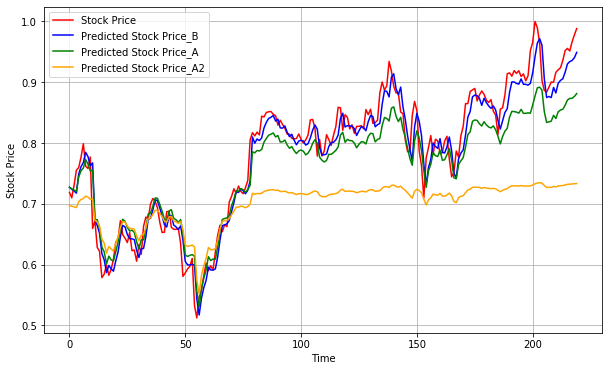

In [0]:
predicted_stock_price_B = model_B.predict(x_test)
predicted_stock_price_A = model_A.predict(x_test)
predicted_stock_price_A2 = model_A2.predict(x_test).reshape(-1, 1)#.squeeze()
print(predicted_stock_price_A.shape)
print(predicted_stock_price_A2.shape)
plt.figure(figsize=(10, 6))
plt.plot(y_test, color = 'red', label = 'Stock Price')
plt.plot(predicted_stock_price_B, color = 'blue', label = 'Predicted Stock Price_B')
plt.plot(predicted_stock_price_A, color = 'green', label = 'Predicted Stock Price_A')
plt.plot(predicted_stock_price_A2, color = 'orange', label = 'Predicted Stock Price_A2')
#plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

모델 A는 모델 B보다 모델 B는 모델 A2보다 더 나쁜것을 확인할 수 있었습니다.

model_B의 valid mse는 5.9098e-04로 가장 높은 정확도를 보였으며, model_A의 경우에는 0.0015로 그 다음으로 높은 정확도를, 마지막으로 model_A2는 0.0145로 가장 나쁜 결과를 보여줍니다.

이러한 결과가 보여주는 것은 단순히 레이어를 많이 쌓는 것이 좋은 결과를 보장한다는 것은 아니라는 것, 그리고 레이어를 설정해줄때는 모델의 특성을 잘 고려해서 설계해줘야한다는 점입니다.

랜덤한 성향이 강한 주식 그래프의 경우에는 레이어를 많이 쌓고, 드랍아웃을 넣는다고 더 좋아지는 것은 아니라는 사실을 보여줍니다.